c:\Users\adi\miniconda3\envs\smart_hans\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


smart_hans_07252022_154259_11_395-432_08_mgy_.csv
smart_hans_07252022_154619_12_431-469_08_mgy_.csv
smart_hans_07252022_155048_13_482-523_08_mny_.csv
smart_hans_07252022_155230_11_402-439_08_mgy_.csv
smart_hans_07312022_160010_5_109-124_08_mny_x.csv
smart_hans_07312022_161226_7_250-280_08_mgy_.csv
smart_hans_07312022_161925_10_313-339_08_mny_.csv
smart_hans_07312022_162132_5_146-170_08_mny_.csv
smart_hans_07312022_162305_9_246-269_08_mny_.csv
smart_hans_07312022_162745_8_272-303_08_mgy_.csv
smart_hans_07312022_164319_11_363-393_08_mny_.csv
smart_hans_07312022_164533_9_305-333_08_mgy_.csv
smart_hans_07312022_164702_5_181-209_08_mgy_.csv
smart_hans_07312022_164838_8_276-305_08_mgy_klatschen_8_ende.csv
smart_hans_07312022_165851_12_402-433_08_mgy_.csv
smart_hans_07312022_170052_6_215-244_08_mgy_.csv
smart_hans_07312022_170216_4_149-178_08_mgy_furz_lachen_am_ende.csv
smart_hans_07312022_170549_7_197-222_08_mnn_.csv
smart_hans_07312022_171246_5_174-198_08_mnn_.csv
smart_hans_07312022_171406

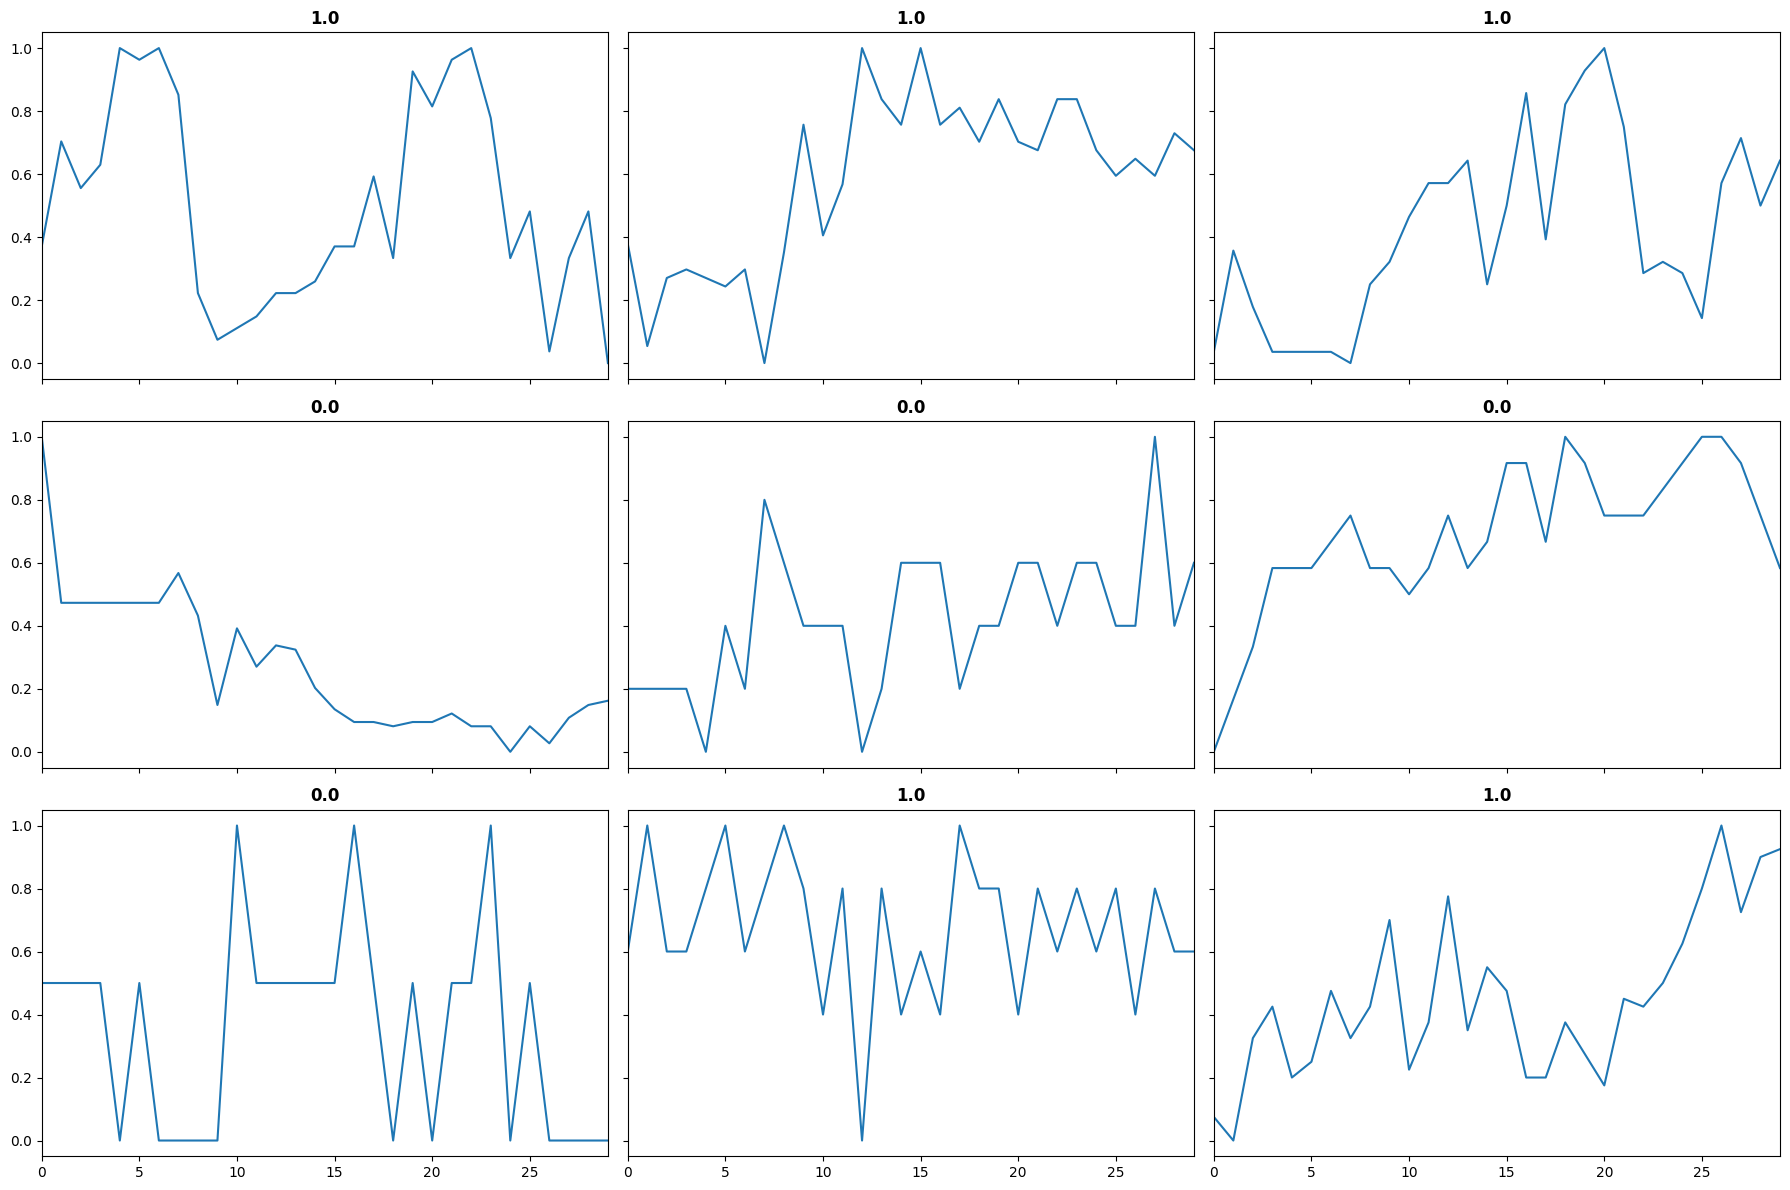

In [1]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader
import datetime
CUDA_LAUNCH_BLOCKING=1

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

num_scenario = 4

nr_taps = 1

tap_size = 30

move_by = -12

learning_cycles = 6

model_to_use = "InceptionTime"

threshold = 0.51

features_to_learn_with = ["chin_y"]
feature_list_string = '_'.join(features_to_learn_with)

models_folder = "models"
plots_folder = "vis/plots"
save_name = "scenario_{}_{}".format(num_scenario, model_to_use)

dl = dataloader(scenario= num_scenario, path="C:/Users/adi/Nextcloud/smart_hans/AP2/Daten/zum_sichten/laeuft", nr_taps=nr_taps, move_window_by=move_by, tap_size=tap_size, feature_list=features_to_learn_with)
train, test, df= dl.train, dl.test, dl.df

X_test, y_test = df2xy(test, target_col='target')
X_train, y_train = df2xy(train, target_col='target')

X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid,  num_workers=0)

print(df.shape)
dls.show_batch(sharey=True)

In [2]:
import optuna
from optuna.integration import FastAIPruningCallback

def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    nf = trial.suggest_categorical('num_filters', [6, 12, 24, 48, 96]) # search through all categorical values in the provided list
    #depth = trial.suggest_int('depth', 3, 9, step=3) # search through all integer values between 3 and 9 with 3 increment steps
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    seq = trial.suggest_int('seq_len', 4, 256, step=20)
    bottleneck = trial.suggest_categorical('bottleneck', [True, False])
    
    

    model = InceptionTime(dls.vars, dls.c, seq_len=seq, bottleneck=bottleneck, nf=nf)
    #model = OmniScaleCNN(dls.vars, dls.c, seq_len=seq, few_shot=bottleneck)
    learn = Learner(dls, model, metrics=accuracy)
##    learn = TSClassifier(X, y, splits=splits,
 #                        arch=InceptionTime, arch_config={'seq_len': seq, 'bottleneck':bottleneck},
#                         metrics=accuracy, cbs=FastAIPruningCallback(trial))
#c_in, c_out, seq_len=None, nf=32, nb_filters=None, ks=40,
 #               bottleneck=True

    with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
        learn.fit_one_cycle(10, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][1]

In [3]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2022-10-23 16:55:40,715] A new study created in memory with name: no-name-6742ac48-3288-4316-b320-77ed60f5e6f9
[I 2022-10-23 16:55:43,672] Trial 0 finished with value: 0.7109219431877136 and parameters: {'num_filters': 48, 'dropout_rate': 0.5, 'learning_rate': 0.0009112759521660829, 'seq_len': 124, 'bottleneck': True}. Best is trial 0 with value: 0.7109219431877136.
[I 2022-10-23 16:55:49,566] Trial 1 finished with value: 1.1596297025680542 and parameters: {'num_filters': 48, 'dropout_rate': 0.2, 'learning_rate': 0.0007562100805889615, 'seq_len': 24, 'bottleneck': False}. Best is trial 0 with value: 0.7109219431877136.
[I 2022-10-23 16:55:50,113] Trial 2 finished with value: 0.6978917121887207 and parameters: {'num_filters': 6, 'dropout_rate': 0.1, 'learning_rate': 1.435803006123439e-05, 'seq_len': 104, 'bottleneck': True}. Best is trial 2 with value: 0.6978917121887207.
[I 2022-10-23 16:55:56,507] Trial 3 finished with value: 0.7414276003837585 and parameters: {'num_filters': 96, '

In [10]:


print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



Study statistics: 
  Number of finished trials:  50
Best trial:
  Value:  0.6795746684074402
  Params: 
    num_filters: 96
    dropout_rate: 0.4
    learning_rate: 3.4894275550564333e-06
    seq_len: 44
    bottleneck: True


In [11]:


display(optuna.visualization.plot_optimization_history(study))
display(optuna.visualization.plot_param_importances(study))
display(optuna.visualization.plot_slice(study))
display(optuna.visualization.plot_parallel_coordinate(study))



In [12]:


# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
nf = trial.params['num_filters']
#depth = trial.params['depth']
dropout_rate = trial.params['dropout_rate']
learning_rate = trial.params['learning_rate']

seq = trial.params['seq_len']
bottleneck = trial.params['bottleneck']



In [16]:
model = InceptionTime(dls.vars, dls.c, seq_len=seq, bottleneck=bottleneck)
#model = OmniScaleCNN(dls.vars, dls.c, seq_len=seq, few_shot=bottleneck)
learn = Learner(dls, model, metrics=accuracy)


learn.fit_one_cycle(10, lr_max=learning_rate)
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')


epoch,train_loss,valid_loss,accuracy,time
0,0.727007,0.697896,0.437500,00:00
1,0.724337,0.691844,0.520833,00:00
2,0.709526,0.688153,0.562500,00:00
3,0.716391,0.685973,0.562500,00:00
4,0.713416,0.684679,0.572917,00:00
5,0.712807,0.683967,0.572917,00:00
6,0.713154,0.683562,0.572917,00:00
7,0.716039,0.683286,0.572917,00:00
8,0.718300,0.683146,0.572917,00:00
9,0.715379,0.683089,0.562500,00:00


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


not enough values to plot a chart


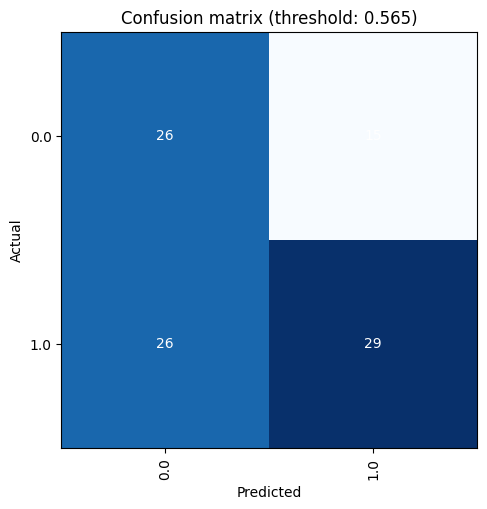

In [27]:
learn.recorder.plot_metrics()
learn.plot_confusion_matrix(thr=0.565)
feature_list_string = '_'.join(features_to_learn_with)
current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
plot_name = plots_folder+"/confusion_matrix_"+save_name+"_nrtaps_{}_features_{}_learning_cycles_{}_{}.png".format(str(nr_taps),feature_list_string,learning_cycles, current_time)

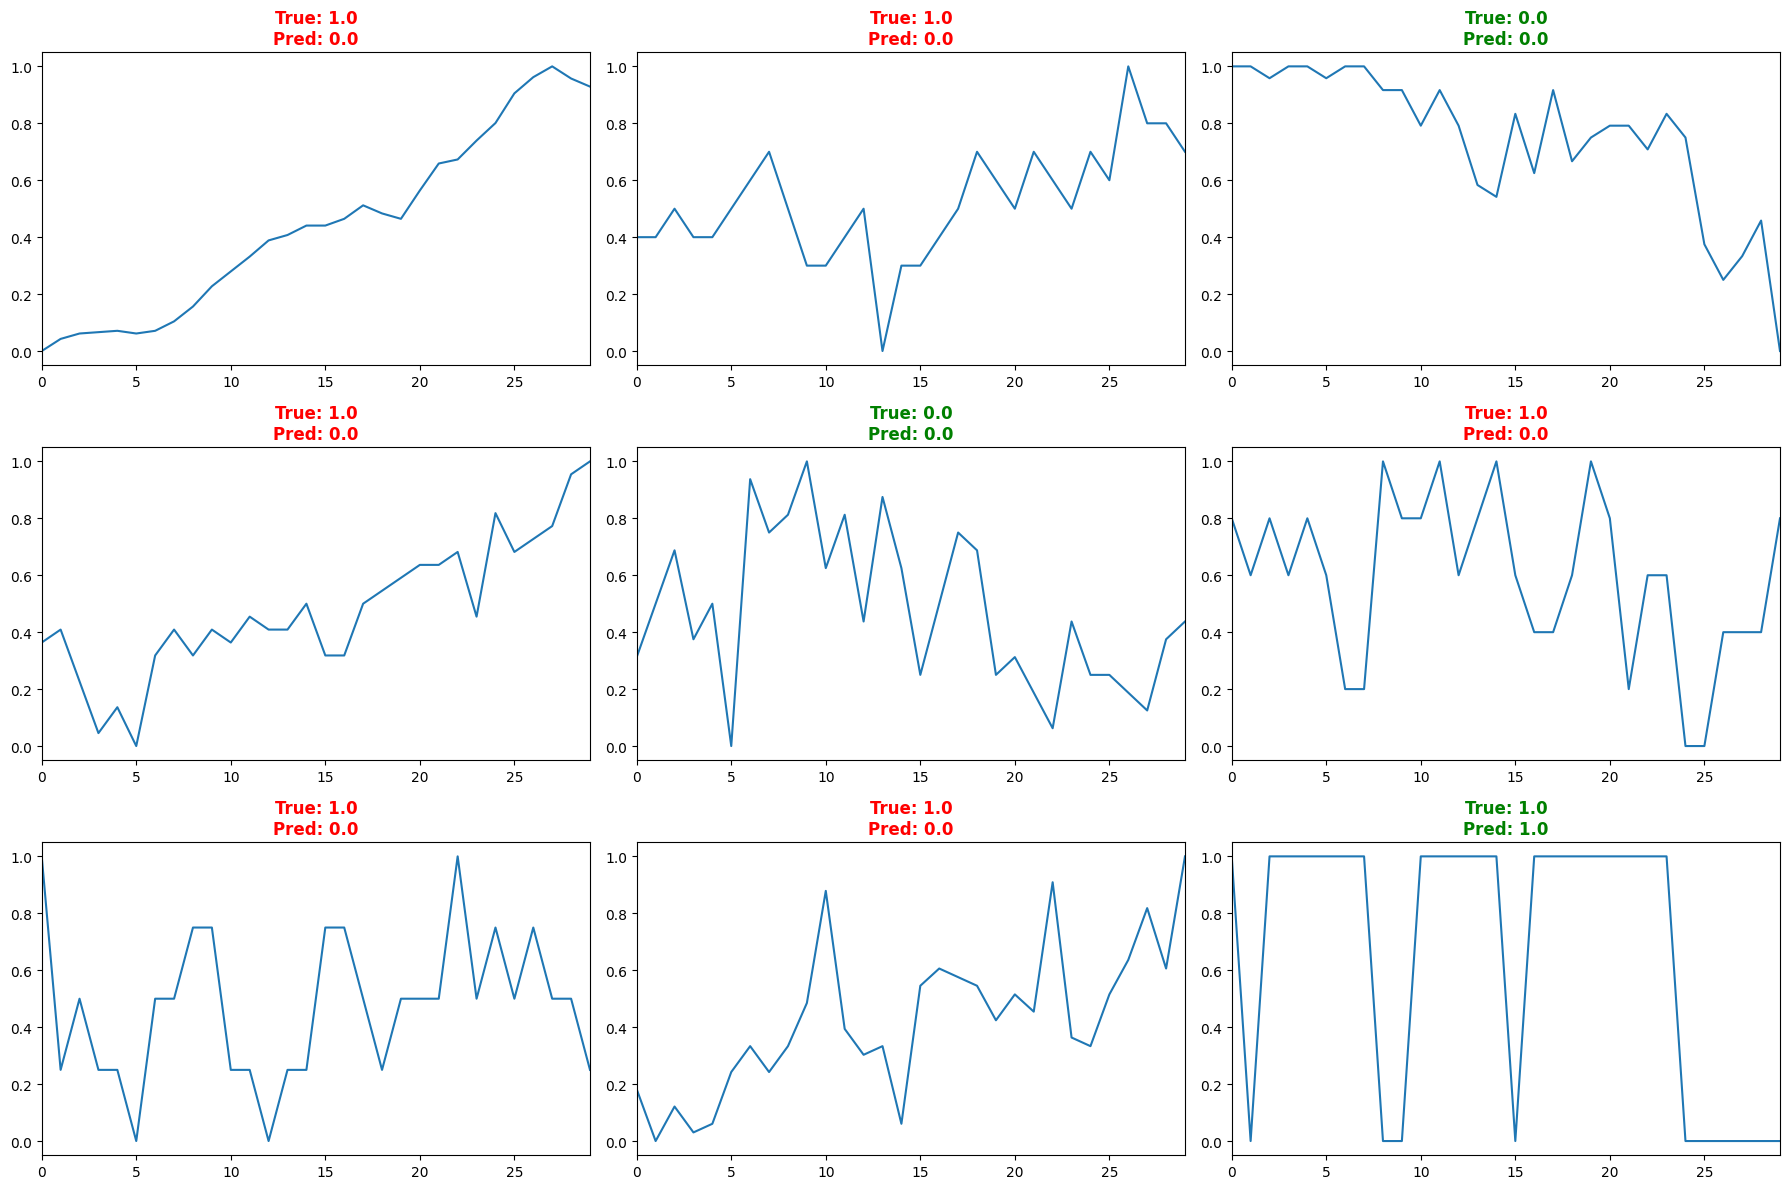

In [9]:
learn.show_results()